# OSE-Summer School 2019
## Econ PS1, Felix Kubler

In [195]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from numpy.polynomial import chebyshev

### 1. Asset market equilibrium

In [184]:
def asset_market_eqm(gamma):
    
    def equations(x):
        # q1 : price of A1
        # q2 : price of A2
        # a1 : agent1's position on A1
        # a2 : agent2's position on A2
        q1, q2, a1, a2 = x
    
        # given parameters
        S = 4
        e1 = np.array([1,1,2,1,2])
        e2 = np.array([1,3,1,3,1])
        A1 = np.array([1,1,1,1])
        A2 = np.array([1,1,1.5,1.5])
    
        # optimality conditions
        eq1 = (e1[0]-q1*a1-q2*a2)**(-gamma)*q1- \
            (1/S)*((e1[1]+a1*A1[0]+a2*A2[0])**(-gamma)*A1[0]+
            (e1[2]+a1*A1[1]+a2*A2[1])**(-gamma)*A1[1]+
            (e1[3]+a1*A1[2]+a2*A2[2])**(-gamma)*A1[2]+
            (e1[4]+a1*A1[3]+a2*A2[3])**(-gamma)*A1[3])
        
        eq2 = (e1[0]-q1*a1-q2*a2)**(-gamma)*q2- \
            (1/S)*((e1[1]+a1*A1[0]+a2*A2[0])**(-gamma)*A2[0]+
            (e1[2]+a1*A1[1]+a2*A2[1])**(-gamma)*A2[1]+
            (e1[3]+a1*A1[2]+a2*A2[2])**(-gamma)*A2[2]+
            (e1[4]+a1*A1[3]+a2*A2[3])**(-gamma)*A2[3])
        
        eq3 = (e2[0]+q1*a1+q2*a2)**(-gamma)*q1- \
            (1/S)*((e2[1]-a1*A1[0]-a2*A2[0])**(-gamma)*A1[0]+
            (e2[2]-a1*A1[1]-a2*A2[1])**(-gamma)*A1[1]+
            (e2[3]-a1*A1[2]-a2*A2[2])**(-gamma)*A1[2]+
            (e2[4]-a1*A1[3]-a2*A2[3])**(-gamma)*A1[3])
        
        eq4 = (e2[0]+q1*a1+q2*a2)**(-gamma)*q2- \
            (1/S)*((e2[1]-a1*A1[0]-a2*A2[0])**(-gamma)*A2[0]+
            (e2[2]-a1*A1[1]-a2*A2[1])**(-gamma)*A2[1]+
            (e2[3]-a1*A1[2]-a2*A2[2])**(-gamma)*A2[2]+
            (e2[4]-a1*A1[3]-a2*A2[3])**(-gamma)*A2[3])
        
        return (eq1,eq2,eq3,eq4)
    
    sol = fsolve(equations, (0.5,1,0,0))
    return sol

In [185]:
sol_gamma2 = asset_market_eqm(2)
sol_gamma4 = asset_market_eqm(4)
sol_gamma8 = asset_market_eqm(8)
sol_gamma166 = asset_market_eqm(166)
print("(gamma=2)   ","(q1,q2,a1,a2) = ",np.round(sol_gamma2,3))
print("(gamma=4)   ","(q1,q2,a1,a2) = ",np.round(sol_gamma4,3))
print("(gamma=8)   ","(q1,q2,a1,a2) = ",np.round(sol_gamma8,3))
print("(gamma=166) ","(q1,q2,a1,a2) = ",np.round(sol_gamma166,3))

(gamma=2)    (q1,q2,a1,a2) =  [0.59  0.737 0.02  0.   ]
(gamma=4)    (q1,q2,a1,a2) =  [ 0.519  0.648  0.004 -0.   ]
(gamma=8)    (q1,q2,a1,a2) =  [ 0.501  0.626  0.    -0.   ]
(gamma=166)  (q1,q2,a1,a2) =  [ 0.5    0.625 -0.     0.   ]


### 2. Dynamic Programming (Tic-Tac-Toe)

In [186]:
def ret_sums(state):
    row_sum = np.sum(state, axis=0)
    col_sum = np.sum(state, axis=1)
    diag_sum = np.array([int(state[0,0])+int(state[1,1])+int(state[2,2]), int(state[2,0])+ int(state[1,1])+ int(state[0,2])])
    return row_sum, col_sum, diag_sum

In [187]:
def check_win(state):
    temp_state = state == 1
    row_sum, col_sum, diag_sum = ret_sums(temp_state)
    check1 = max([np.sum(row_sum>2), np.sum(col_sum>2), np.sum(diag_sum>2)])
    temp_state = state == -1
    row_sum, col_sum, diag_sum = ret_sums(temp_state)
    check2 = max([np.sum(row_sum>2), np.sum(col_sum>2), np.sum(diag_sum>2)])
    return max(check1, check2)

In [188]:
state = np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]])
while not check_win(state):
    print(state)
    valid = True
    while valid:
        print('Enter coordinate: row')
        p1x = input()
        print('Enter coordinate: column')
        p1y = input()        
        try:
            if state[int(p1x),int(p1y)] != 0:
                print('Invalid, try again.')
            else:
                state[int(p1x),int(p1y)] = 1
                valid = False
        except:
            print('Invalid, try again.')
    if check_win(state):
            print('you win!')
            break
    try:
        # 1. dynamic programming logic: cycle through available coords, if can win now, choose that cord
        # 2. otherwise min continuation value, that is, choose a coord to block p1's win, if possible
        # 3. if no threats, randomize (or randomize blocking coords)
        
        avail_cords = [(i,j) for i,j in zip(*np.where(state==0))] 
        # 1. dynamic programming logic: cycle through available coords, if can win now, choose that cord
        win_cord = None
        winning = False
        for cord in avail_cords:
            temp_state = state.copy()
            temp_state[cord] = -1
            if check_win(temp_state):
                winning = True
                win_cord = cord
        if winning:
            state[win_cord] = -1
        # 2. otherwise min continuation value, that is, choose a coord to block p1's win, if possible
        else:
            possible_cords = []
            for cord in avail_cords:
                temp_state = state.copy()
                temp_state[cord] = -1
                temp_avail_cords = [(i,j) for i,j in zip(*np.where(temp_state==0))] 
                p1_win = False
                for cord2 in temp_avail_cords:
                    temp_state2 = temp_state.copy()
                    temp_state2[cord2] = 1
                    if check_win(temp_state2):
                        p1_win = True
                if not p1_win:
                    possible_cords.append(cord)
        # 3. if no threats, randomize (or randomize blocking coords)
            state[random.choice(possible_cords)] = -1        
    except:
        if not check_win(state):
            print('draw')
            break
    finally:
        if check_win(state):
            print('computer wins!')
            break
print(state)
state = np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]])

[[ 0  0  0]
 [ 0  0  0]
 [-1  0  0]]
Enter coordinate: row
0
Enter coordinate: column
0
[[ 1  0  0]
 [ 0 -1  0]
 [-1  0  0]]
Enter coordinate: row
1
Enter coordinate: column
1
Invalid, try again.
Enter coordinate: row
2
Enter coordinate: column
2
computer wins!
[[ 1  0 -1]
 [ 0 -1  0]
 [-1  0  1]]


### 3. Ramsey I

In [189]:
def ramsey_VFI(beta,kmin,kmax,nk):
    ## input
    # beta : discount factor
    # kmin : minimum value of capital
    # kmax : maximum value of capital
    # nk   : the number of capital grids
    
    # capital grid
    kgrid = np.linspace(kmin,kmax,num=nk)

    # transition matrix
    pi = np.array([0.5,0.5])

    # required matrices and vectors
    mY = np.zeros((len(kgrid),len(pi)),dtype=float)    # save output
    mV = np.zeros_like(mY)                             # save values for value function
    mPk = np.zeros_like(mY)                            # save optimal capital choice
    eV = np.zeros_like(mY)                             # save expected continuation value
    mVnew = np.zeros_like(mY)                          # save values for value function

    # production function
    def production(k,j):
        if j==0:
            f = 0.9*k**0.3 + 0.3*k
        else:
            f = 1.1*k**0.3 + 0.9*k
        return f

    # output
    for j in range(len(pi)):
        mY[:,j] = production(kgrid,j)

    # Value function iteration
    diff = 10
    it = 0
    tol = 10e-6

    while(diff > tol):
        
        it = it + 1
        eV = np.dot(mV,pi)
        
        for j in range(len(pi)):
            
            VV = -10000.0
            index = 0
            
            for ik in range(len(kgrid)):
                
                for ikp in range(index,len(kgrid)):
                    
                    cons = mY[ik,j]-kgrid[ikp]
                    val = np.log(cons) + beta*eV[ikp]
                
                    if val > VV:
                        VV = val
                        kp = kgrid[ikp]
                        index = ikp
                    else:
                        break
                    
                mVnew[ik,j] = VV
                mPk[ik,j] = kp
            
        diff = np.max(abs(mVnew-mV))
        mV = mVnew
        mVnew = np.zeros((len(kgrid),len(pi)),dtype=float)
    
    print("Iteration = ",it,",  diff = ",diff)
    
    # figures (f1 : value function, f2 : policy function)
    f1 = plt.figure()
    f2 = plt.figure()
    ax1 = f1.add_subplot(111)
    ax1.plot(kgrid,mV)
    ax1.legend(["z=1","z=2"])
    ax1.set_title('value function')
    ax2 = f2.add_subplot(111)
    ax2.plot(kgrid,mPk)
    ax2.legend(["z=1","z=2"])
    ax2.set_title('policy function')
    plt.show()
    
    return mPk, kgrid

Iteration =  105 ,  diff =  9.995752350278053e-06


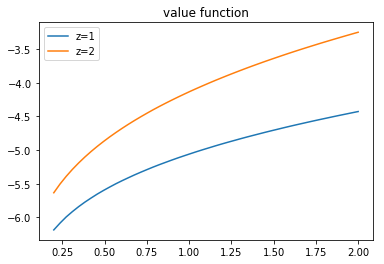

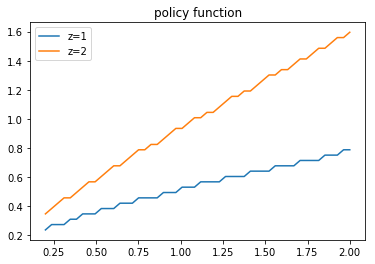

In [190]:
beta, kmin, kmax = 0.9, 0.2, 2.0

# the number of capital points = 50
mPk, kgrid = ramsey_VFI(beta,kmin,kmax,50)

Iteration =  105 ,  diff =  9.990483335720057e-06


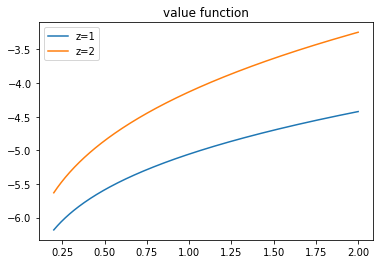

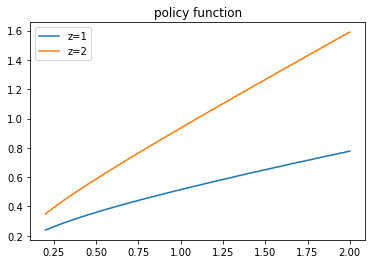

In [191]:
# the number of capital points = 500
mPk, kgrid = ramsey_VFI(beta,kmin,kmax,500)

## 4. The Stochastic Ramsey Model - time iteration collocation

### a. policy time iteration with piecewise linear interpolation

In [192]:
def up(x):
    return 1/x

def f1(k):
    return 0.9*k**0.3 + 0.3*k

def f2(k):
    return 1.1*k**0.3 + 0.9*k

def fp1(k):
    return 0.27*k**(-0.7) + 0.3

def fp2(k):
    return 0.33*k**(-0.7) + 0.9

def euler_eq(kp,*args):
    j, beta, k, interp1, interp2 = args
    if j == 0:
        eq = beta * 0.5 * (up(f1(kp) - interp1(kp)) * fp1(kp) +
                    up(f2(kp) - interp2(kp)) * fp2(kp)) - up(f1(k)-kp)
    else:
        eq = beta * 0.5 * (up(f1(kp) - interp1(kp)) * fp1(kp) +
                    up(f2(kp) - interp2(kp)) * fp2(kp)) - up(f2(k)-kp)
    return abs(eq)

def ramsey_PTI(maxiter,tol,numPiece,kmin,kmax):
    
    it = 0
    diff = 10
    
    # capital grid
    kgrid = np.linspace(kmin,kmax,num=(numPiece+1))
    nk = len(kgrid)
    
    Pknew = np.ones((nk,2))
    
    while (diff > tol) and (it < maxiter):

        it += 1
        Pk = Pknew.copy()        
        
        interp1 = interp1d(kgrid, Pk[:,0], kind='linear', fill_value='extrapolate')
        interp2 = interp1d(kgrid, Pk[:,1], kind='linear', fill_value='extrapolate')
                    
        for ik in range(nk):
            
            k = kgrid[ik]
            
            args1 = (0, 0.9, k, interp1, interp2)
            sol1 = fsolve(euler_eq,kmin,args1)
            Pknew[ik,0] = sol1
            
            args2 = (1, 0.9, k, interp1, interp2)
            sol2 = fsolve(euler_eq,kmin,args2)
            Pknew[ik,1] = sol2

        diff = np.max(abs(Pk - Pknew))
    
    print("Iteration = ",it,",  diff = ",diff)
    
    # figures (f1 : value function, f2 : policy function)
    plt.plot(kgrid,Pk)
    plt.legend(["z=1","z=2"])
    plt.title('policy function')
    plt.show()
    
    return Pk, kgrid

/home/dohan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/dohan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()
/home/dohan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  
/home/dohan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


Iteration =  21 ,  diff =  5.66103470767132e-07


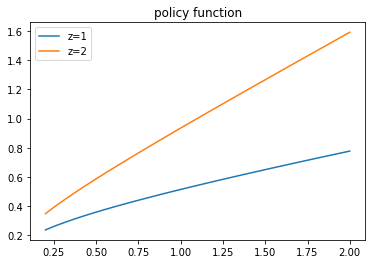

In [193]:
maxiter, tol, numPiece, kmin, kmax = 100, 1e-6, 30, 0.2, 2.0
Pk, kgrid = ramsey_PTI(maxiter,tol,numPiece,kmin,kmax)

### Chebyshev Polynomials of 5 degree

In [205]:
def zeros_of_chebyshev_polynomials(nd, kmin, kmax):
    kgrid = np.zeros(nd+1)
    m = np.size(kgrid)
    for i in range(m):
        kgrid[i] = -np.cos(((2*(i+1)-1.)/(2*m))*np.pi)
    kgrid = 0.5*(kmin+kmax)+0.5*(kmax-kmin)*kgrid
    kgrid.sort()
    return kgrid

def chebyshev_coef(kgrid, Pk, nd):
    coef = chebyshev.chebfit(kgrid, Pk, nd)
    return coef

def ramsey_chebyshev(maxiter,tol,nd,kmin,kmax):
    
    it = 0
    diff = 10
    
    # capital grid
    kgrid = zeros_of_chebyshev_polynomials(nd, kmin, kmax)
    
    Pknew = np.ones((nd+1,2))
    
    while (diff > tol) and (it < maxiter):

        it += 1
        Pk = Pknew.copy()
        
        coef1 = chebyshev_coef(kgrid,Pk[:,0],nd)
        coef2 = chebyshev_coef(kgrid,Pk[:,1],nd)
        
        interp1 = lambda x : chebyshev.chebval(x, coef1)
        interp2 = lambda x : chebyshev.chebval(x, coef2)
        nk = nd + 1
            
        for ik in range(nk):
            
            k = kgrid[ik]
            
            args1 = (0, 0.9, k, interp1, interp2)
            sol1 = fsolve(euler_eq,kmin,args1)
            Pknew[ik,0] = sol1
            
            args2 = (1, 0.9, k, interp1, interp2)
            sol2 = fsolve(euler_eq,kmin,args2)
            Pknew[ik,1] = sol2

        diff = np.max(abs(Pk - Pknew))
    
    print("Iteration = ",it,",  diff = ",diff)
    
    # figures (f1 : value function, f2 : policy function)
    plt.plot(kgrid,Pk)
    plt.legend(["z=1","z=2"])
    plt.title('policy function')
    plt.show()
    
    return Pk, kgrid

Iteration =  21 ,  diff =  5.623985961378253e-07


/home/dohan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/dohan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()
/home/dohan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  
/home/dohan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


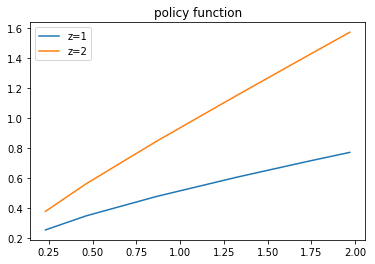

In [206]:
maxiter, tol, nd, kmin, kmax = 100, 1e-6, 5, 0.2, 2.0
Pk, kgrid = ramsey_chebyshev(maxiter,tol,nd,kmin,kmax)

### b. tensor products